In [1]:
# Google Colab setup
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/My Drive/adl4cv")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# ONLY NECESSARY FOR LOCAL EXECUTION (WORKS WITHOUT THIS CELL IN GOOGLE COLAB)
# Setup that is necessary for jupyter notebook to find sibling-directories
# see: https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [0]:
# FROM i2dl for nice setup
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [0]:
# Imports for this notebook

from networks.baseline import BaselineModel
from training.solver import Solver
from training.single_image_dataloader import FaceForensicsImagesDataset, ToTensor
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
import torch

In [0]:
data_location = ["/content/drive/My Drive/FaceForensics_Sequences/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform",
                 "/content/drive/My Drive/FaceForensics_Sequences/manipulated_sequences/Deepfakes/c40/sequences_299x299_5seq@10frames_skip_5_uniform"]
dataset = FaceForensicsImagesDataset(data_location, transform=ToTensor())

In [5]:
# from: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

batch_size = 10
validation_split = .2

# Creating data indices for training and validation splits:
train_indices, val_indices = dataset.get_train_val_lists(1 - validation_split, validation_split)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

print("Train samples: {}".format(len(train_loader)))
print("Validation samples: {}".format(len(validation_loader)))

#for i, sample in enumerate(train_loader):
    
    #print("count of sequences in this batch: {}".format(sample["images"][0].shape[0]))
    
    #sequence = sample["images"][0][0, :, :, :, :]
    #labels_for_sequence = sample["labels"]
    #print(labels_for_sequence)
    
    #print(sequence.shape)
    #img = sequence[0].numpy()
    #img = np.moveaxis(img, 0, -1)  
    #plt.imshow(img)
    #plt.show()
    
    
    #print(sample["images"][0].shape)
    #print(sample["labels"][0].shape)

Train samples: 720
Validation samples: 180


In [6]:
# Load baseline model
model = BaselineModel(model_choice='xception', num_out_classes=2, dropout=0.0)
model.train_only_last_layer()

print(model)
print("----------")
print("Only the following layers require gradient backpropagation (param.requires_grad)")
for name, param in model.model.named_parameters():
    if param.requires_grad:
        print("param: {} requires_grad: {}".format(name, param.requires_grad))

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/checkpoints/xception-43020ad28.pth
100%|██████████| 87.4M/87.4M [04:17<00:00, 356kB/s]

BaselineModel(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp

In [7]:
#configure solver and start training
solver = Solver(optim=torch.optim.Adam,
                optim_args={ "lr": 1e-4,
                             "betas": (0.9, 0.999),
                             "eps": 1e-8,
                             "weight_decay": 0.0}, # is the l2 regularization parameter, see: https://pytorch.org/docs/stable/optim.html
                loss_func=torch.nn.CrossEntropyLoss())

# Baseline must be trained to get the last classification layer to work correctly, because Xception-net is pretrained on
# ImageNet with 1000 class outputs and we only need 2.

solver.train(model, train_loader, validation_loader, num_epochs=1, log_nth=1)

START TRAIN on device: cuda:0
[Iteration 1/720] TRAIN loss: 0.6855854988098145
[Iteration 2/720] TRAIN loss: 0.6901168823242188
[Iteration 3/720] TRAIN loss: 0.6903411746025085
[Iteration 4/720] TRAIN loss: 0.7005955576896667
[Iteration 5/720] TRAIN loss: 0.7121652960777283
[Iteration 6/720] TRAIN loss: 0.7169417142868042
[Iteration 7/720] TRAIN loss: 0.7035855054855347
[Iteration 8/720] TRAIN loss: 0.6587950587272644
[Iteration 9/720] TRAIN loss: 0.6951094269752502
[Iteration 10/720] TRAIN loss: 0.6734022498130798
[Iteration 11/720] TRAIN loss: 0.6957934498786926
[Iteration 12/720] TRAIN loss: 0.6887425184249878
[Iteration 13/720] TRAIN loss: 0.6724006533622742
[Iteration 14/720] TRAIN loss: 0.6743676662445068
[Iteration 15/720] TRAIN loss: 0.6920250654220581
[Iteration 16/720] TRAIN loss: 0.6405638456344604
[Iteration 17/720] TRAIN loss: 0.6848465204238892
[Iteration 18/720] TRAIN loss: 0.6419966220855713
[Iteration 19/720] TRAIN loss: 0.7026101350784302
[Iteration 20/720] TRAIN loss

In [0]:
'''
print(dataset.__len__())
print(dataset.shape)
train_dataset = dataset[:20]
val_dataset = dataset[20:]

print(train_dataset.__len__())
print(val_dataset.__len__())


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

#for i, sample in enumerate(train_loader):
#    print(sample["images"][0].shape)
#    print(sample["labels"][0].shape)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

#solver.train(model, train_loader, val_loader, num_epochs=2, log_nth=1000)
'''

In [18]:
test_data_location = ["/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform",
                 "/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/Deepfakes/c40/sequences_299x299_5seq@10frames_skip_5_uniform"]
test_dataset = FaceForensicsImagesDataset(test_data_location, transform=ToTensor())

test_indices = range(len(test_dataset))

test_sampler = SubsetRandomSampler(test_indices)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                           sampler=test_sampler)

print("Length of test dataset: {}".format(len(test_dataset)))

from torch.autograd import Variable
model.eval()  # EVAL mode (for dropout, batchnorm, etc.)
with torch.no_grad():
    test_losses = []
    test_acc = []
    for sample in test_loader:
        xb = sample["image"]
        yb = sample["label"]

        xb, yb = Variable(xb), Variable(yb)
        #if str(device) != 'cpu':
        xb, yb = xb.cuda(), yb.cuda()


        #xb, yb = wrap_data(xb, yb, device)

        # FORWARD PASS --> Loss calculation
        loss_func = torch.nn.CrossEntropyLoss()
        scores = model(xb)
        loss = loss_func(scores, yb)
        loss = loss.data.cpu().numpy()
        test_losses.append(loss)
      
        _, preds = torch.max(scores, 1) # select highest value as the predicted class
        #y_mask = yb >= 0 # do not allow "-1" segmentation value
        acc = np.mean((preds == yb).data.cpu().numpy())  # check if prediction is correct + average of it for all N inputs

        test_acc.append(acc)

        print("---intermediate test acc: {} loss: {}".format(acc, loss))

    test_loss = np.mean(test_losses)
    test_acc = np.mean(test_acc)

    print("TEST: acc: {} loss: {}".format(test_acc, test_loss))


Length of test dataset: 998
---intermediate test acc: 1.0 loss: 0.19158989191055298
---intermediate test acc: 1.0 loss: 0.4565700590610504
---intermediate test acc: 1.0 loss: 0.1792561411857605
---intermediate test acc: 1.0 loss: 0.3902878761291504
---intermediate test acc: 1.0 loss: 0.3729513883590698
---intermediate test acc: 1.0 loss: 0.2307721972465515
---intermediate test acc: 1.0 loss: 0.43468016386032104
---intermediate test acc: 1.0 loss: 0.285015344619751
---intermediate test acc: 1.0 loss: 0.3550790548324585
---intermediate test acc: 1.0 loss: 0.6074437499046326
---intermediate test acc: 1.0 loss: 0.13549774885177612
---intermediate test acc: 1.0 loss: 0.24583011865615845
---intermediate test acc: 1.0 loss: 0.24725943803787231
---intermediate test acc: 1.0 loss: 0.12277400493621826
---intermediate test acc: 1.0 loss: 0.07096230983734131
---intermediate test acc: 1.0 loss: 0.13203716278076172
---intermediate test acc: 1.0 loss: 0.1577167510986328
---intermediate test acc: 1.0 

In [19]:
test_data_location = ["/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform",
                 "/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/FaceSwap/c40/sequences_299x299_5seq@10frames_skip_5_uniform"]
test_dataset = FaceForensicsImagesDataset(test_data_location, transform=ToTensor())

test_indices = range(len(test_dataset))

test_sampler = SubsetRandomSampler(test_indices)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                           sampler=test_sampler)

print("Length of test dataset: {}".format(len(test_dataset)))

from torch.autograd import Variable
model.eval()  # EVAL mode (for dropout, batchnorm, etc.)
with torch.no_grad():
    test_losses = []
    test_acc = []
    for sample in test_loader:
        xb = sample["image"]
        yb = sample["label"]

        xb, yb = Variable(xb), Variable(yb)
        #if str(device) != 'cpu':
        xb, yb = xb.cuda(), yb.cuda()


        #xb, yb = wrap_data(xb, yb, device)

        # FORWARD PASS --> Loss calculation
        loss_func = torch.nn.CrossEntropyLoss()
        scores = model(xb)
        loss = loss_func(scores, yb)
        loss = loss.data.cpu().numpy()
        test_losses.append(loss)
      
        _, preds = torch.max(scores, 1) # select highest value as the predicted class
        #y_mask = yb >= 0 # do not allow "-1" segmentation value
        acc = np.mean((preds == yb).data.cpu().numpy())  # check if prediction is correct + average of it for all N inputs

        test_acc.append(acc)

    test_loss = np.mean(test_losses)
    test_acc = np.mean(test_acc)

    print("TEST: acc: {} loss: {}".format(test_acc, test_loss))


Length of test dataset: 998
TEST: acc: 0.5711422845691383 loss: 0.7208824157714844


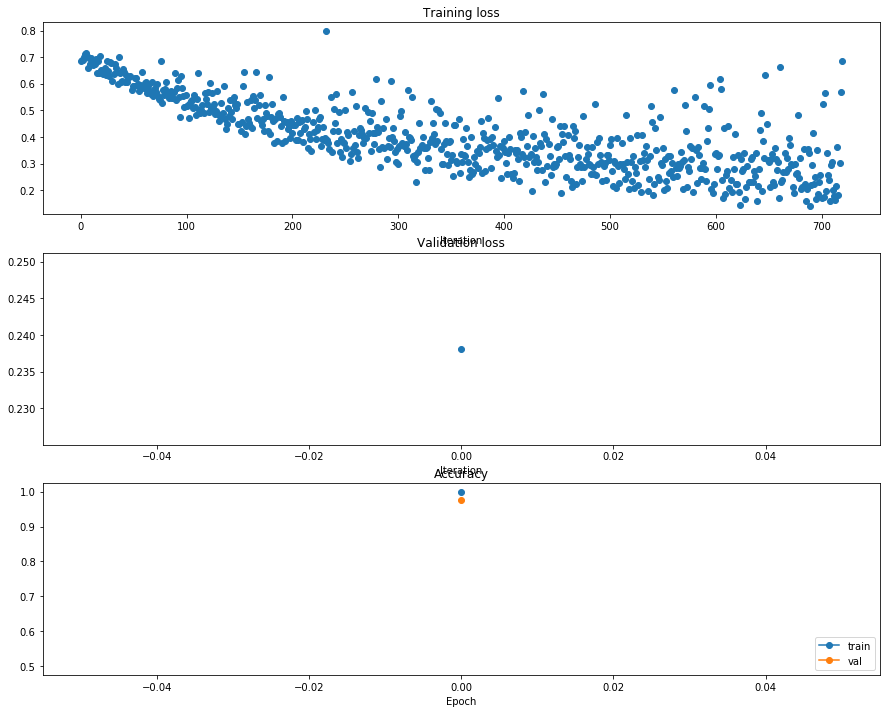

In [14]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.plot(solver.train_loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Validation loss')
plt.plot(solver.val_loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(3, 1, 3)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()